In [81]:
import pandas as pd
import numpy as np
df=pd.read_csv(r'/home/saswata/data_science/UM_projects/world_population/world_population.csv')
df

,Rank,CCA3,Country/Territory,Capital,Continent,2022 Population,2020 Population,2015 Population,2010 Population,2000 Population,1990 Population,1980 Population,1970 Population,Area (km²),Density (per km²),Growth Rate,World Population Percentage
0,36,AFG,Afghanistan,Kabul,Asia,41128771,38972230,33753499,28189672,19542982,10694796,12486631,10752971,652230,63.0587,1.0257,0.52
1,138,ALB,Albania,Tirana,Europe,2842321,2866849,2882481,2913399,3182021,3295066,2941651,2324731,28748,98.8702,0.9957,0.04
2,34,DZA,Algeria,Algiers,Africa,44903225,43451666,39543154,35856344,30774621,25518074,18739378,13795915,2381741,18.8531,1.0164,0.56
3,213,ASM,American Samoa,Pago Pago,Oceania,44273,46189,51368,54849,58230,47818,32886,27075,199,222.4774,0.9831,0.00
4,203,AND,Andorra,Andorra la Vella,Europe,79824,77700,71746,71519,66097,53569,35611,19860,468,170.5641,1.0100,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,226,WLF,Wallis and Futuna,Mata-Utu,Oceania,11572,11655,12182,13142,14723,13454,11315,9377,142,81.4930,0.9953,0.00
230,172,ESH,Western Sahara,El Aaiún,Africa,575986,556048,491824,413296,270375,178529,116775,76371,266000,2.1654,1.0184,0.01
231,46,YEM,Yemen,Sanaa,Asia,33696614,32284046,28516545,24743946,18628700,13375121,9204938,6843607,527968,63.8232,1.0217,0.42
232,63,ZMB,Zambia,Lusaka,Africa,20017675,18927715,16248230,13792086,9891136,7686401,5720438,4281671,752612,26.5976,1.0280,0.25


In [82]:
import pandas as pd
import statsmodels.api as sm

# --- Melt the Data ---
pop_cols = [col for col in df.columns if 'Population' in col and 'World' not in col]
df_melted = df.melt(
    id_vars=['Country/Territory', 'Area (km²)', 'Growth Rate'],
    value_vars=pop_cols,
    var_name='Year',
    value_name='Population'
)
df_melted['Year'] = df_melted['Year'].str.extract(r'(\d{4})').astype(int)
df_melted['Date'] = pd.to_datetime(df_melted['Year'].astype(str) + '-01-01')  # Set date as 1st Jan of each year
df_melted.sort_values(by=['Country/Territory', 'Date'], inplace=True)

# --- Feature Engineering ---
df_melted['Density'] = df_melted['Population'] / df_melted['Area (km²)']

# Initialize Growth and Growth Rate Δ with NaN
df_melted['Growth'] = pd.NA

# Set Growth and Growth Rate Δ for the first year (1970) as 0
df_melted.loc[df_melted['Year'] == 1970, 'Growth'] = 0

# Calculate Growth and Growth Rate Δ, starting from 1971 (second year)
for country in df_melted['Country/Territory'].unique():
    country_df = df_melted[df_melted['Country/Territory'] == country].sort_values(by='Year').copy()
    
    # Calculate Growth (change in population relative to previous year) and Growth Rate Δ (difference of Growth)
    for i in range(1, len(country_df)):
        current_year = country_df.iloc[i]
        previous_year = country_df.iloc[i-1]
        
        # Calculate Growth Rate (change in population from previous year to current year)
        growth_rate = (current_year['Population'] - previous_year['Population']) / previous_year['Population']
        df_melted.loc[(df_melted['Country/Territory'] == country) & (df_melted['Year'] == current_year['Year']), 'Growth'] = growth_rate
        


# --- Extrapolation for 1970 ---
# After calculating growth for subsequent years, we can extrapolate growth for the first year.
# We'll simply carry forward the second year’s growth and growth rate change to the first year.

for country in df_melted['Country/Territory'].unique():
    country_df = df_melted[df_melted['Country/Territory'] == country].copy()
    
    # Extrapolate growth and rate of change of growth rate from second year to the first year
    if 1971 in country_df['Year'].values:
        growth_2nd_year = country_df[country_df['Year'] == 1971]['Growth'].values[0]
        
        # Extrapolate using 2nd year's values for the first year
        df_melted.loc[(df_melted['Country/Territory'] == country) & (df_melted['Year'] == 1970), 'Growth'] = growth_2nd_year

df_melted = df_melted.drop(['Growth Rate'], axis=1)
df_melted.head(20)

,Country/Territory,Area (km²),Year,Population,Date,Density,Growth
1638,Afghanistan,652230,1970,10752971,1970-01-01,16.486471,0
1404,Afghanistan,652230,1980,12486631,1980-01-01,19.144521,0.161226
1170,Afghanistan,652230,1990,10694796,1990-01-01,16.397277,-0.1435
936,Afghanistan,652230,2000,19542982,2000-01-01,29.963329,0.827336
702,Afghanistan,652230,2010,28189672,2010-01-01,43.220447,0.442445
468,Afghanistan,652230,2015,33753499,2015-01-01,51.750915,0.197371
234,Afghanistan,652230,2020,38972230,2020-01-01,59.752281,0.154613
0,Afghanistan,652230,2022,41128771,2022-01-01,63.058692,0.055335
1639,Albania,28748,1970,2324731,1970-01-01,80.865834,0
1405,Albania,28748,1980,2941651,1980-01-01,102.325414,0.265373


In [83]:
all_years = pd.DataFrame({'Year': range(1970, 2023)})
interpolated_dfs = []

for country in df_melted['Country/Territory'].unique():
    country_df = df_melted[df_melted['Country/Territory'] == country].copy()

    merged = pd.merge(all_years, country_df, on='Year', how='left')
    merged['Country/Territory'] = country
    merged['Area (km²)'] = merged['Area (km²)'].ffill()

    # Interpolate population
    merged['Population'] = merged['Population'].interpolate(method='linear')

    # Recompute Date and Density
    merged['Date'] = pd.to_datetime(merged['Year'].astype(str) + '-01-01')
    merged['Density'] = merged['Population'] / merged['Area (km²)']

    # Recompute Growth as % change
    merged['Growth'] = merged['Population'].pct_change()
    merged.loc[0, 'Growth'] = merged.loc[1, 'Growth']  # Extrapolate first year

    interpolated_dfs.append(merged)

df_full = pd.concat(interpolated_dfs, ignore_index=True)
df_full.sort_values(by=['Country/Territory', 'Year'], inplace=True)

df_full

,Year,Country/Territory,Area (km²),Population,Date,Density,Growth
0,1970,Afghanistan,652230.0,10752971.0,1970-01-01,16.486471,0.016123
1,1971,Afghanistan,652230.0,10926337.0,1971-01-01,16.752276,0.016123
2,1972,Afghanistan,652230.0,11099703.0,1972-01-01,17.018081,0.015867
3,1973,Afghanistan,652230.0,11273069.0,1973-01-01,17.283886,0.015619
4,1974,Afghanistan,652230.0,11446435.0,1974-01-01,17.549691,0.015379
...,...,...,...,...,...,...,...
12397,2018,Zimbabwe,390757.0,15063774.4,2018-01-01,38.550236,0.020524
12398,2019,Zimbabwe,390757.0,15366720.2,2019-01-01,39.325515,0.020111
12399,2020,Zimbabwe,390757.0,15669666.0,2020-01-01,40.100794,0.019714
12400,2021,Zimbabwe,390757.0,15995101.5,2021-01-01,40.933628,0.020769


In [21]:
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Grouped ARIMA Forecast Function
def forecast_arima(series, steps=10, seasonal=False, m=1):
    # Drop NaNs
    series = series.dropna()
    
    # Stationarity check
    adf_pval = adfuller(series)[1]
    d = 0 if adf_pval < 0.05 else 1

    # Auto ARIMA to choose p, d, q
    model = auto_arima(series, seasonal=seasonal, m=m, d=d, trace=False, suppress_warnings=True)
    
    # Forecast
    forecast = model.predict(n_periods=steps)
    return forecast, model

# Storage
forecast_results = {}

# Loop through countries
for country in df_full['Country/Territory'].unique():
    country_df = df_full[df_full['Country/Territory'] == country].sort_values('Year')
    
    growth_series = country_df.set_index('Year')['Growth'].astype(float)

    # Predict next 5 years of Growth
    growth_forecast, growth_model = forecast_arima(growth_series, steps=10)
    

    forecast_results[country] = {
        'growth_forecast': growth_forecast,
        'growth_model': growth_model,
    }

# Example: Print for Afghanistan
country = 'Afghanistan'
print(f"Forecasted Growth (next 5 years): {forecast_results[country]['growth_forecast']}")



Forecasted Growth (next 5 years): 53    0.026923
54    0.026923
55    0.026923
56    0.026923
57    0.026923
58    0.026923
59    0.026923
60    0.026923
61    0.026923
62    0.026923
dtype: float64


In [84]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_encoded = df_full.copy()
df_encoded['Country/Territory'] = le.fit_transform(df_encoded['Country/Territory'])

# 3. Define X and y
x = df_encoded.drop(['Growth', 'Date'], axis=1)
y = df_encoded['Growth']
y = y.astype(float)

In [85]:
from sklearn.preprocessing import StandardScaler
x_copy = x.copy()
x.iloc[40:61]

,Year,Country/Territory,Area (km²),Population,Density
40,2010,0,652230.0,28189672.0,43.220447
41,2011,0,652230.0,29302437.4,44.926540
42,2012,0,652230.0,30415202.8,46.632634
43,2013,0,652230.0,31527968.2,48.338727
44,2014,0,652230.0,32640733.6,50.044821
45,2015,0,652230.0,33753499.0,51.750915
46,2016,0,652230.0,34797245.2,53.351188
47,2017,0,652230.0,35840991.4,54.951461
48,2018,0,652230.0,36884737.6,56.551734
49,2019,0,652230.0,37928483.8,58.152007


In [86]:
y

0        0.016123
1        0.016123
2        0.015867
3        0.015619
4        0.015379
           ...   
12397    0.020524
12398    0.020111
12399    0.019714
12400    0.020769
12401    0.020346
Name: Growth, Length: 12402, dtype: float64

In [87]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [88]:
model_xgb = xgb.XGBRegressor()
model_lgb = lgb.LGBMRegressor()
model_rf = RandomForestRegressor()
model_dt = DecisionTreeRegressor()
model_svr = SVR()
model_knn = KNeighborsRegressor()
model_linr = LinearRegression()
models=[model_xgb,model_lgb,model_rf,model_dt,model_svr,model_knn,model_linr]
model_names = ['XGBoost', 'LightGBM', 'RandomForest', 'DecisionTree', 'SVR', 'KNN', 'LinearRegression']

In [89]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

results = []
years = [f"Year_{y}" for y in range(2023, 2023 + 10)]
unique_countries = x['Country/Territory'].unique()

# Fit scaler on full data
scaler = StandardScaler()
x[['Population', 'Density']] = scaler.fit_transform(x[['Population', 'Density']])
x.index = x_copy.index  # Make sure index is retained

for country in unique_countries:
    print(f"Processing Country ID: {country}")
    
    # Filter scaled and unscaled data
    x_c = x[x['Country/Territory'] == country].copy()
    x_c_real = x_copy[x_copy['Country/Territory'] == country].copy()
    y_c = y.loc[x['Country/Territory'] == country].copy()
    
    x_c_features = x_c.drop(columns=['Country/Territory'])
    x_last = x_c_features.iloc[-1].copy()
    
    last_pop = x_c_real.iloc[-1]['Population']
    area = x_c_real.iloc[-1]['Area (km²)']
    last_year = x_c_real.iloc[-1]['Year']

    for name, model in zip(model_names, models):
        try:
            model.fit(x_c_features, y_c)

            country_rows = []
            pop_temp = last_pop
            year_temp = last_year

            for _ in range(10):
                y_next = model.predict(x_last.values.reshape(1, -1))[0]

                pop_temp = pop_temp * (1 + y_next)
                dens_temp = pop_temp / area
                year_temp += 1

                country_rows.append({
                    'Country': country,
                    'Model': name,
                    'Area (km²)': area,
                    'Year': year_temp,
                    'Population': pop_temp,
                    'Density': dens_temp,
                    'Predicted_Growth': y_next
                })

                # Prepare next scaled input
                pop_scaled, dens_scaled = scaler.transform([[pop_temp, dens_temp]])[0]
                x_last['Population'] = pop_scaled
                x_last['Density'] = dens_scaled
                x_last['Year'] = year_temp

            results.extend(country_rows)
        except Exception as e:
            print(f"Error with {name} on country {country}: {e}")


results_df = pd.DataFrame(results)
print(results_df.head())


Processing Country ID: 0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 0.026266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [92]:
results_df.head(20)

,Country,Model,Area (km²),Year,Population,Density,Predicted_Growth
0,0,XGBoost,652230.0,2023.0,4.227551e+07,64.816880,0.027882
1,0,XGBoost,652230.0,2024.0,4.345423e+07,66.624088,0.027882
2,0,XGBoost,652230.0,2025.0,4.466581e+07,68.481685,0.027882
3,0,XGBoost,652230.0,2026.0,4.591117e+07,70.391074,0.027882
4,0,XGBoost,652230.0,2027.0,4.719125e+07,72.353701,0.027882
5,0,XGBoost,652230.0,2028.0,4.850703e+07,74.371049,0.027882
6,0,XGBoost,652230.0,2029.0,4.985949e+07,76.444645,0.027882
7,0,XGBoost,652230.0,2030.0,5.124966e+07,78.576056,0.027882
8,0,XGBoost,652230.0,2031.0,5.267859e+07,80.766894,0.027882
9,0,XGBoost,652230.0,2032.0,5.414736e+07,83.018817,0.027882


In [93]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assuming label encoding already done on df_encoded and label_to_country exists
x_temp = df_full.copy()
x_temp = x_temp.drop(['Growth', 'Date'], axis=1)

# Create mapping from label to country
label_to_country = dict(zip(le.transform(le.classes_), le.classes_))

# Sort the original data
x_copy_sorted = x_temp.sort_values(by=['Country/Territory', 'Year'])

# Decode country labels in results_df
results_df['Decoded_Country'] = results_df['Country'].map(label_to_country)

# Store final model-specific DataFrames
model_dfs = {}

for model_name in results_df['Model'].unique():
    all_countries_data = []

    model_df = results_df[results_df['Model'] == model_name]

    for country in model_df['Decoded_Country'].unique():
        # Get historical data
        past_data = x_copy_sorted[x_copy_sorted['Country/Territory'] == country].copy()
        past_data = past_data.sort_values(by='Year')
        # Add original growth column from df_full
        growth_data = df_full[(df_full['Country/Territory'] == country)][['Year', 'Growth']]
        past_data = past_data.merge(growth_data, on='Year', how='left')

        # Get predicted data
        preds_df = model_df[model_df['Decoded_Country'] == country].copy()
        preds_df = preds_df[['Decoded_Country', 'Area (km²)', 'Year', 'Population', 'Density', 'Predicted_Growth']]
        preds_df.rename(columns={
            'Decoded_Country': 'Country/Territory',
            'Predicted_Growth': 'Growth'
        }, inplace=True)

        # Combine historical and predicted data
        combined_df = pd.concat([past_data, preds_df], ignore_index=True)
        all_countries_data.append(combined_df)

    model_dfs[model_name] = pd.concat(all_countries_data, ignore_index=True)

# Display sample combined DataFrames
for model_name, model_df in model_dfs.items():
    print(f"Model: {model_name}")
    print(model_df.head())



Model: XGBoost
     Year Country/Territory  Area (km²)  Population    Density    Growth
0  1970.0       Afghanistan    652230.0  10752971.0  16.486471  0.016123
1  1971.0       Afghanistan    652230.0  10926337.0  16.752276  0.016123
2  1972.0       Afghanistan    652230.0  11099703.0  17.018081  0.015867
3  1973.0       Afghanistan    652230.0  11273069.0  17.283886  0.015619
4  1974.0       Afghanistan    652230.0  11446435.0  17.549691  0.015379
Model: LightGBM
     Year Country/Territory  Area (km²)  Population    Density    Growth
0  1970.0       Afghanistan    652230.0  10752971.0  16.486471  0.016123
1  1971.0       Afghanistan    652230.0  10926337.0  16.752276  0.016123
2  1972.0       Afghanistan    652230.0  11099703.0  17.018081  0.015867
3  1973.0       Afghanistan    652230.0  11273069.0  17.283886  0.015619
4  1974.0       Afghanistan    652230.0  11446435.0  17.549691  0.015379
Model: RandomForest
     Year Country/Territory  Area (km²)  Population    Density    Growth


In [94]:
model_dfs['XGBoost'].iloc[50:70]

,Year,Country/Territory,Area (km²),Population,Density,Growth
50,2020.0,Afghanistan,652230.0,3.897223e+07,59.752281,0.027519
51,2021.0,Afghanistan,652230.0,4.005050e+07,61.405487,0.027668
52,2022.0,Afghanistan,652230.0,4.112877e+07,63.058692,0.026923
53,2023.0,Afghanistan,652230.0,4.227551e+07,64.816880,0.027882
54,2024.0,Afghanistan,652230.0,4.345423e+07,66.624088,0.027882
55,2025.0,Afghanistan,652230.0,4.466581e+07,68.481685,0.027882
56,2026.0,Afghanistan,652230.0,4.591117e+07,70.391074,0.027882
57,2027.0,Afghanistan,652230.0,4.719125e+07,72.353701,0.027882
58,2028.0,Afghanistan,652230.0,4.850703e+07,74.371049,0.027882
59,2029.0,Afghanistan,652230.0,4.985949e+07,76.444645,0.027882


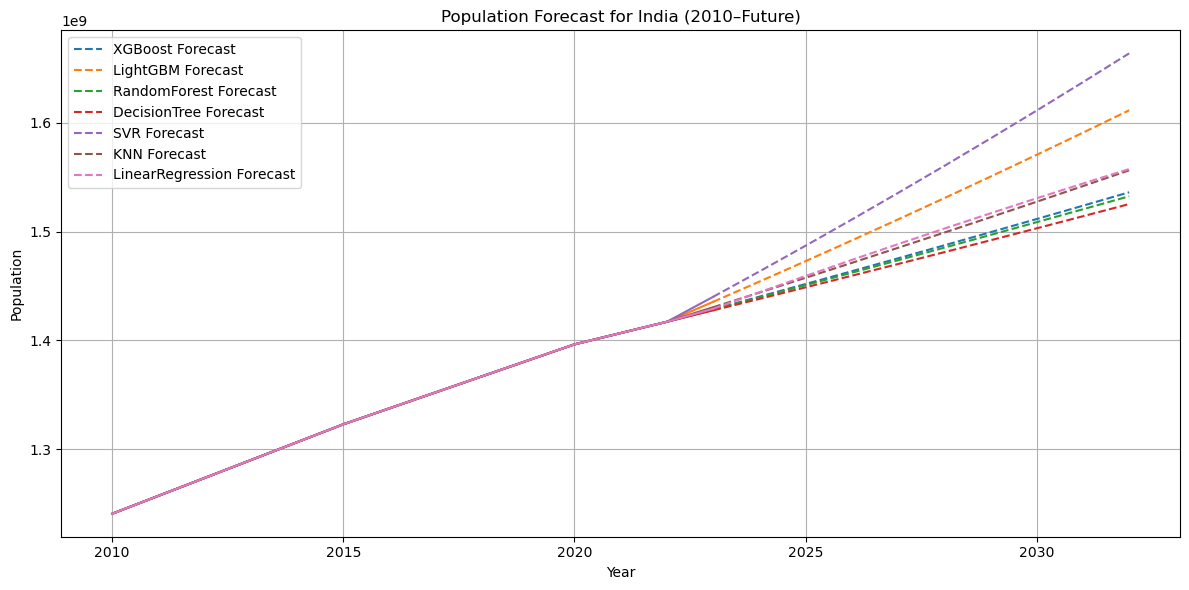

In [99]:
split_year = 2023  # prediction starts from 2023
start_year = 2010
country = 'India'

plt.figure(figsize=(12, 6))

for model_name, model_df in model_dfs.items():
    df_india = model_df[model_df['Country/Territory'] == country].sort_values('Year')
    df_india = df_india[df_india['Year'] >= start_year]

    df_hist = df_india[df_india['Year'] <= split_year]
    df_pred = df_india[df_india['Year'] >= split_year]

    if not df_hist.empty:
        line, = plt.plot(df_hist['Year'], df_hist['Population'], linestyle='-')  # no label here
    if not df_pred.empty:
        plt.plot(df_pred['Year'], df_pred['Population'], linestyle='--', color=line.get_color(), label=f"{model_name} Forecast")

plt.title(f"Population Forecast for {country} (2010–Future)")
plt.xlabel("Year")
plt.ylabel("Population")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

